# Seminar Project: Subsetting Speeches
---------------
``` 

Jakob Amann
Elias Gabriel Heppner, 1244414
Andri Rutschmann

### Loading Packages


In [13]:
import numpy as np 
import pandas as pd 
import time
import pickle
import time
import os
import datetime
import zipfile
# from t    qdm.auto import tqdm
from tqdm import tqdm # use this import for better kaggle compatibility
from collections import defaultdict 
import re
import matplotlib.pyplot as plt
import math
import json
import random

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import pipeline


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jakob\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Speeches Data


In [4]:
# # For kaggle, just reload .pkl and .jsons

# # file_path = '/kaggle/input/sub-speeches-data-input/sub_speeches.pkl'
# file_path = '/kaggle/input/preprocessed-speeches/parliament_speeches.pkl' # for preprocseed speeches
# df = pd.read_pickle(file_path)
# print(df.isna().any())
# df.head()


# file_path_llm_par = '/kaggle/input/gpt-outputs-politricks/gpt_output/llm_speeches_party.json' 
# with open(file_path_llm_par, 'r') as file:
#     llm_speeches_party = json.load(file)


# file_path_llm_pol = '/kaggle/input/gpt-outputs-politricks/gpt_output/llm_speeches_pol.json'
# with open(file_path_llm_pol, 'r') as file:
#     llm_speeches_pol = json.load(file)

# file_path_llm_pol_par = '/kaggle/input/gpt-outputs-politricks/gpt_output/llm_speeches_pol_party.json'
# with open(file_path_llm_pol_par, 'r') as file:
#     llm_speeches_pol_party = json.load(file)

In [3]:
# # For Local Use
# print(os.getcwd())
# os.chdir("../data")

# # zip_file_path = "sub_speeches.zip"
# zip_file_path = r"sub_speeches.pkl.zip" # changed it to pickle file as .csv introduced NA values

# # Name of the CSV file inside the zip file
# # csv_filename = "sub_speeches.csv"
# pkl_filename = r"sub_speeches.pkl"

# # Open the zip file
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     # Check if the CSV file exists in the zip file
#     if pkl_filename in zip_ref.namelist():
#         # Extract the CSV file
#         with zip_ref.open(pkl_filename) as csv_file:
#             # Read the CSV file using pandas
#             # df = pd.read_csv(csv_file)
#             df = pd.read_pickle(csv_file)

#             print(df.head())  # Display the first few rows of the dataframe
#     else:
#         print(f"{pkl_filename} not found in the zip file.")

# df.isna().any()



os.chdir("../data/kaggle_outputs")
# reload covid, migration and ukraine_war speeches from .pkl files
covid_speeches = pd.read_pickle('covid_speeches_manifestoberta.pkl')
migration_speeches = pd.read_pickle('migration_speeches_manifestoberta.pkl')
ukraine_war_speeches = pd.read_pickle('ukraine_war_speeches_manifestoberta.pkl')


# reload jsons with manifestoberta outputs
file_path_llm_par = r'llm_speeches_party_manifestoberta.json' 
with open(file_path_llm_par, 'r', encoding='utf-8') as file:
    llm_speeches_party = json.load(file)

file_path_llm_pol = r'llm_speeches_pol_manifestoberta.json'
with open(file_path_llm_pol, 'r', encoding='utf-8') as file:
    llm_speeches_pol = json.load(file)

file_path_llm_pol_par = r'llm_speeches_pol_party_manifestoberta.json'
with open(file_path_llm_pol_par, 'r', encoding='utf-8') as file:
    llm_speeches_pol_party = json.load(file)

## Topic-Selection for Speeches using RegEx 

This was already done and can be skipped as we already reloaded the already preprocessed files earlier. 

In [21]:
# # we need to look at speech_content
#     # Let's start with Ukraine War
# fin_df = df.copy()

# # regex pattern to match speeches about the war on Ukraine
# pattern_ukraine_war = r'(?i)\b(Krieg|Konflikt|Invasion|Krise|Angriffskrieg|conflict|crisis)\b.*\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b|\b(Ukraine|Kyiv|Donbas|Krim|Kiew|Russland|Putin|Moskau)\b.'
# matches_ukraine_war = fin_df['speech_content'].str.contains(pattern_ukraine_war, case=False, flags=re.IGNORECASE)
# ukraine_war_speeches = fin_df[matches_ukraine_war]
# print(len(ukraine_war_speeches))


# # now Covid
# pattern_covid = r'(?i)\b(COVID-19|Coronavirus|Pandemie|SARS-CoV-2|Quarantäne|Lockdown|Social Distancing|Ausgangsbeschränkung(en)?|Maskenpflicht|Impfpass|Corona-Virus|Infektion(en)?|Gesundheitsnotstand|Impfpflicht)\b'
# matches_covid = fin_df['speech_content'].str.contains(pattern_covid, case=False, flags=re.IGNORECASE)
# covid_speeches = fin_df[matches_covid]
# print(len(covid_speeches))

# # now Migration 
# pattern_migration = r'(?i)\b(Flüchtlinge?|Migration|Asylbewerber?|Geflüchtete?|Asylverfahren|Einwanderer?|Auswanderer?|Immigrant(en)?|Emigrant(en)?|Zuwanderer?|Vertriebene?|Schutzsuchende?|Migranten?|Asylrecht|Grenzübergang|Visapolitik|Einreiseverbot)\b'
# matches_migration = fin_df['speech_content'].str.contains(pattern_migration, case=False, flags=re.IGNORECASE)
# migration_speeches = fin_df[matches_migration]
# print(len(migration_speeches))

# Topic Modelling using Parlbert-Topic-German

In [3]:
def classify_speeches(speeches, pipeline_classification_topics, max_length=250):
    """
    Classify a list of speeches into topics using batching.
    
    :param speeches: List of speech texts.
    :param pipeline_classification_topics: The classification pipeline.
    :param max_length: Maximum token length for each chunk.
    :return: List of most common topics for each speech.
    """
    batched_topics = []
    start_time = time.time()
    for speech in speeches:
        tokens = word_tokenize(speech, language='german')
        # Split speech into chunks
        token_chunks = [' '.join(tokens[i:i + max_length]) for i in range(0, len(tokens), max_length)]
        if not token_chunks:  # Handle case where speech might be empty or very short
            batched_topics.append(None)
            continue

        # Process all chunks at once using the pipeline
        topics_in_speech = pipeline_classification_topics(token_chunks)
        # Find the most common topic in the speech
        topics = [topic['label'] for topic in topics_in_speech]
        most_common_topic = max(set(topics), key=topics.count)
        batched_topics.append(most_common_topic)
    end_time = time.time()
#     print(f'For {len(speeches)} speeches, it took {end_time-start_time} seconds')
    return batched_topics


In [ ]:
### Execution of Topic Modelling
# implemented for complete df, then for ukraine_war-, covid-, migration-speeches

# batch_size = 10  # adjust batch size
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# pipeline_classification_topics = pipeline("text-classification", model="chkla/parlbert-topic-german", return_all_scores=False, device=device, truncation=False)

# results = []
# for start in tqdm(range(0, len(df), batch_size)):
#     end = start + batch_size
#     speeches_batch = df['speech_content'][start:end]#.tolist()
#     batch_results = classify_speeches(speeches_batch, pipeline_classification_topics)
#     results.extend(batch_results)
#     if start %3000==0: # every 3000th row, we make a safety copy
#          with open(f'results_lists/results_topic_label_last_row_{end}.pkl', 'wb') as f:
#                 pickle.dump(results, f)

# # Add results to DataFrame
# df['topic_label'] = results
# # df['topic_label'] = tqdm(df['speech_content'].apply(get_topic_from_speech)) # old approach, no loop necessary, no batching


# output_dir = "/kaggle/working/kaggle_outputs_final"
# os.makedirs(output_dir, exist_ok=True)
# output_file_path = os.path.join(output_dir, "parliament_speeches_with_topics.pkl")
# df.to_pickle(output_file_path)



  0%|          | 68/36053 [1:46:37<634:25:32, 63.47s/it]  

# Groundtruthing using Manifestoberta


Let's go with the sentence model as the context model adds just a mere 7% accuracy and is way more complex to implement. I think, we'd have to use each sentence + it's previous/following sentence as context.

The sentence model should be used for sentences, but let's check if there are any restrictions and/or problems arising, when we give multiple sentences.

In [24]:
model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1") # https://huggingface.co/manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    model = model.cuda()

def get_average_dimension_values(speech_in_sentences):
    '''
    input: 
    speech_in_sentences: a whole speech/article as list of strings/sentences. Each single object should have at max 200 tokens to be usable for the model 

    output:
    dimension_values_dict: dict with all dimensions, sorted by the highest values with manifesto_dimensions as keys
    '''
    sum_probabilities = defaultdict(float)  # this makes sure we have just 0.0 if the key was not found
    for sentence in speech_in_sentences:
        inputs = tokenizer(sentence,
                           return_tensors="pt",
                           max_length=200,  # we limited the input to 200 tokens during finetuning
                           padding="max_length",
                           truncation=True
                           ).to(device)

        with torch.no_grad():  # Inference mode, no gradients needed
            logits = model(**inputs).logits
        probabilities = torch.softmax(logits, dim=1).cpu().tolist()[0]
        probabilities = {model.config.id2label[index]: round(probability * 100, 2) for index, probability in enumerate(probabilities)}
        for dimension, probability in probabilities.items():
            sum_probabilities[dimension] += probability

    # calculate average probabilities for each dimension
    avg_probabilities = {dimension: round(total / len(speech_in_sentences), 2) for dimension, total in sum_probabilities.items()}
    avg_probabilities_sorted = dict(sorted(avg_probabilities.items(), key=lambda item: item[1], reverse=True))
    return avg_probabilities_sorted


## Groundtruhting Real Speeches

In [23]:
# model = AutoModelForSequenceClassification.from_pretrained("manifesto-project/manifestoberta-xlm-roberta-56policy-topics-sentence-2023-1-1")
# tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# if torch.cuda.is_available():
#     model = model.cuda()

# # Manifestoberta for ukraine_war, covid and migration speeches (original speeches)
# result_dict_list = [] 
# for speech in tqdm(ukraine_war_speeches['speech_content'], miniters = 1): # first two speeches already take around 2.45 min
#     speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
#     result_dict = get_average_dimension_values(speech_in_sentences)
#     result_dict_list.append(result_dict)
# with open(f'results_lists/all_results_ukraine_war.pkl', 'wb') as f:
#                 pickle.dump(result_dict_list, f)
# results_df = pd.DataFrame(result_dict_list)
# ukraine_war_speeches = pd.concat([ukraine_war_speeches.reset_index(drop=True), results_df], axis=1)
# ukraine_war_speeches.to_pickle('ukraine_war_speeches_manifestoberta.pkl')

# result_dict_list = [] 
# for speech in tqdm(migration_speeches['speech_content'], miniters = 1): # first two speeches already take around 2.45 min
#     speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
#     result_dict = get_average_dimension_values(speech_in_sentences)
#     result_dict_list.append(result_dict)
# with open(f'results_lists/all_results_migration.pkl', 'wb') as f:
#                 pickle.dump(result_dict_list, f)
# results_df = pd.DataFrame(result_dict_list)
# migration_speeches = pd.concat([migration_speeches.reset_index(drop=True), results_df], axis=1)
# migration_speeches.to_pickle('migration_speeches_manifestoberta.pkl')

# result_dict_list = [] 
# for speech in tqdm(covid_speeches['speech_content'], miniters = 1): # first two speeches already take around 2.45 min
#     speech_in_sentences = nltk.tokenize.sent_tokenize(speech)
#     result_dict = get_average_dimension_values(speech_in_sentences)
#     result_dict_list.append(result_dict)
# with open(f'results_lists/all_results_covid.pkl', 'wb') as f:
#             pickle.dump(result_dict_list, f)
# results_df = pd.DataFrame(result_dict_list)
# covid_speeches = pd.concat([covid_speeches.reset_index(drop=True), results_df], axis=1)
# covid_speeches.to_pickle('covid_speeches_manifestoberta.pkl')


## Groundtruthing Artificial Speeches

In [70]:
# gpt_outputs = [llm_speeches_party, llm_speeches_pol, llm_speeches_pol_party]
# gpt_outputs_names = ['llm_speeches_party', 'llm_speeches_pol', 'llm_speeches_pol_party']

# topics = ['Ukraine-Krieg', 'Covid-19', 'Migration']
# counter = 0

# for index, (output, output_name) in enumerate(zip(gpt_outputs, gpt_outputs_names)):
#     modified_output_data = [] # this holds the modified output data, which be added to a list and stored
#     for pol_party_output in output: # we iterate over each party/pol
#         if 'manifestoberta_output' not in pol_party_output:
#             pol_party_output['manifestoberta_output'] = {}
#         for topic in topics: 
#             individual_speeches = pol_party_output['llm_output'][topic]
#             manifestoberta_outputs_list = []
#             for speech in individual_speeches: 
#                 counter += 1
#                 cleaned_speech = re.sub('(?=\[).*(?!\])', '', speech)
#                 cleaned_speech_in_sentences = nltk.tokenize.sent_tokenize(cleaned_speech)
#                 manifestoberta_output = get_average_dimension_values(cleaned_speech_in_sentences)
#                 manifestoberta_outputs_list.append(manifestoberta_output)

#             pol_party_output['manifestoberta_output'][topic] = manifestoberta_outputs_list # this line needs to be changed
#         modified_output_data.append(pol_party_output) # here, we make sure we get back the same structure as the input but with the added column

#     filename = f"{output_name}_manifestoberta.json"
#     file_path = os.path.join("/kaggle/working/", filename)

#     os.makedirs(os.path.dirname(file_path), exist_ok=True)

#     with open(file_path, 'w', encoding='utf-8') as f:
#         json.dump(modified_output_data, f, ensure_ascii=False, indent=4)

#     print(f"Saved: {file_path}")

# Exploration & Evaluation 

In [4]:
# Take care of varying ways to write DIE LINKE
ukraine_war_speeches['abbreviation'] = ukraine_war_speeches['abbreviation'].replace('DIE LINKE.', 'DIE LINKE')
covid_speeches['abbreviation'] = covid_speeches['abbreviation'].replace('DIE LINKE.', 'DIE LINKE')
migration_speeches['abbreviation'] = migration_speeches['abbreviation'].replace('DIE LINKE.', 'DIE LINKE')

### Visualisations
Let's make some example visualisations using the axis, military: Positive/Negative and European Community/Union: Positive/Negative. 


In [229]:
## Used data 
# covid_speeches 
# migration_speeches 
# ukraine_war_speeches 
# llm_speeches_pol 
# llm_speeches_pol_party 
# llm_speeches_party 

ukraine_war_speeches.columns

Index(['id_x', 'session', 'electoral_term', 'date', 'document_url',
       'speech_content', 'politician_id', 'first_name', 'last_name',
       'faction_id', 'abbreviation', 'full_name', 'position_short',
       'position_long', 'speech_tokenized', 'tokenized_length',
       '605 - Law and Order: Positive', '305 - Political Authority',
       '601 - National Way of Life: Positive',
       '201 - Freedom and Human Rights', '107 - Internationalism: Positive',
       '202 - Democracy', '503 - Equality: Positive',
       '414 - Economic Orthodoxy',
       '303 - Governmental and Administrative Efficiency',
       '608 - Multiculturalism: Negative', '607 - Multiculturalism: Positive',
       '506 - Education Expansion', '411 - Technology and Infrastructure',
       '504 - Welfare State Expansion', '602 - National Way of Life: Negative',
       '501 - Environmental Protection: Positive',
       '108 - European Community/Union: Positive',
       '701 - Labour Groups: Positive', '606 - Civic M

In [187]:
party_colors = {
    'CDU/CSU': 'blue',
    'SPD': 'red',
    'AfD': 'cyan',
    'FDP': 'yellow',
    'DIE LINKE': 'purple',
    'Grüne': 'green',
}

def plot_dimension_comparison(llm_speeches, df_speeches, topic_of_interest, dims_x, dims_y, party_colors=party_colors, show_party_averages=False):
    '''
    Plots a comparison of LLM-generated speeches and real Bundestag speeches based on specified dimensions.

    Parameters:
    - llm_speeches: List of dictionaries from .json.
    - df_speeches: DataFrame of speeches (e.g., covid_speeches, migration_speeches, war_on_ukraine_speeches).
    - topic_of_interest: 'Ukraine-Krieg', 'Covid-19', 'Migration'.
    - dims_x, dims_y: List of dimensions from ManifestoBERTa. Use list for 1 or 2 dimensions per axis. For 2, the first is subtracted from the second.
    - party_colors: Dictionary mapping party names to colors.
    - show_party_averages: Boolean to plot party averages instead of individual points.

    '''
    def calculate_value(speeches, dimensions):
        for speech in speeches: # handle missing manifestobert ratings
            if len(speech.keys()) == 0: 
                print(f'No Manifestoberta Rating found, removing speech. ')
                speeches.remove(speech)
        if len(dimensions) == 1:
            return np.mean([speech[dimensions[0]] for speech in speeches if dimensions[0] in speech])
        elif len(dimensions) == 2:
            dim1_values = [speech[dimensions[0]] for speech in speeches if dimensions[0] in speech]
            dim2_values = [speech[dimensions[1]] for speech in speeches if dimensions[1] in speech]
            return np.mean(dim1_values) - np.mean(dim2_values)

    plt.figure(figsize=(12, 12))

    if show_party_averages: # Plot party averages
        for party, color in party_colors.items():
            x_values = []
            y_values = []
            for d in llm_speeches:
                if d['party'] == party:
                    speeches = d['manifestoberta_output'][topic_of_interest]
                    x_values.append(calculate_value(speeches, dims_x))
                    y_values.append(calculate_value(speeches, dims_y))
            if x_values and y_values:  # If there are values to plot
                plt.scatter(np.mean(x_values), np.mean(y_values), color=color, edgecolor='k', marker='o', s=100, label=f"{party} (Artificial)")
        
        for party, color in party_colors.items():
            df_filtered = df_speeches[df_speeches['abbreviation'] == party]
            if not df_filtered.empty:
                speeches = df_filtered.to_dict('records')
                avg_x = calculate_value(speeches, dims_x)
                avg_y = calculate_value(speeches, dims_y)
                plt.scatter(avg_x, avg_y, color=color, edgecolor='k', marker='d', s=100, label=f"{party} (Real)")
    else: # Plot all individual values
        for d in llm_speeches:
            speeches = d['manifestoberta_output'][topic_of_interest]
            x_values = [calculate_value([speech], dims_x) for speech in speeches if all(dim in speech for dim in dims_x)]
            y_values = [calculate_value([speech], dims_y) for speech in speeches if all(dim in speech for dim in dims_y)]
            plt.scatter(x_values, y_values, color=party_colors.get(d['party'], 'black'), label=f"{d['party']} (Artificial)")
        
        for party, color in party_colors.items():
            df_filtered = df_speeches[df_speeches['abbreviation'] == party]
            if not df_filtered.empty:
                speeches = df_filtered.to_dict('records')
                x_values = [calculate_value([speech], dims_x) for speech in speeches if all(dim in speech for dim in dims_x)]
                y_values = [calculate_value([speech], dims_y) for speech in speeches if all(dim in speech for dim in dims_y)]
                plt.scatter(x_values, y_values, color=color, edgecolor='k', marker='d', s=100, label=f"{party} (Real)")

    plt.xlabel(' - '.join(dims_x)) # we join on a minus as we substract the values if we have multiple dimensions
    plt.ylabel(' - '.join(dims_y))
    plt.title(f'{topic_of_interest}: Comparison of LLM-Generated Speeches and Party Values')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))  # Remove duplicates
    plt.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1), ncol=1)
    plt.subplots_adjust(right=0.75) # Adjust subplot to make room for legend
    plt.show()



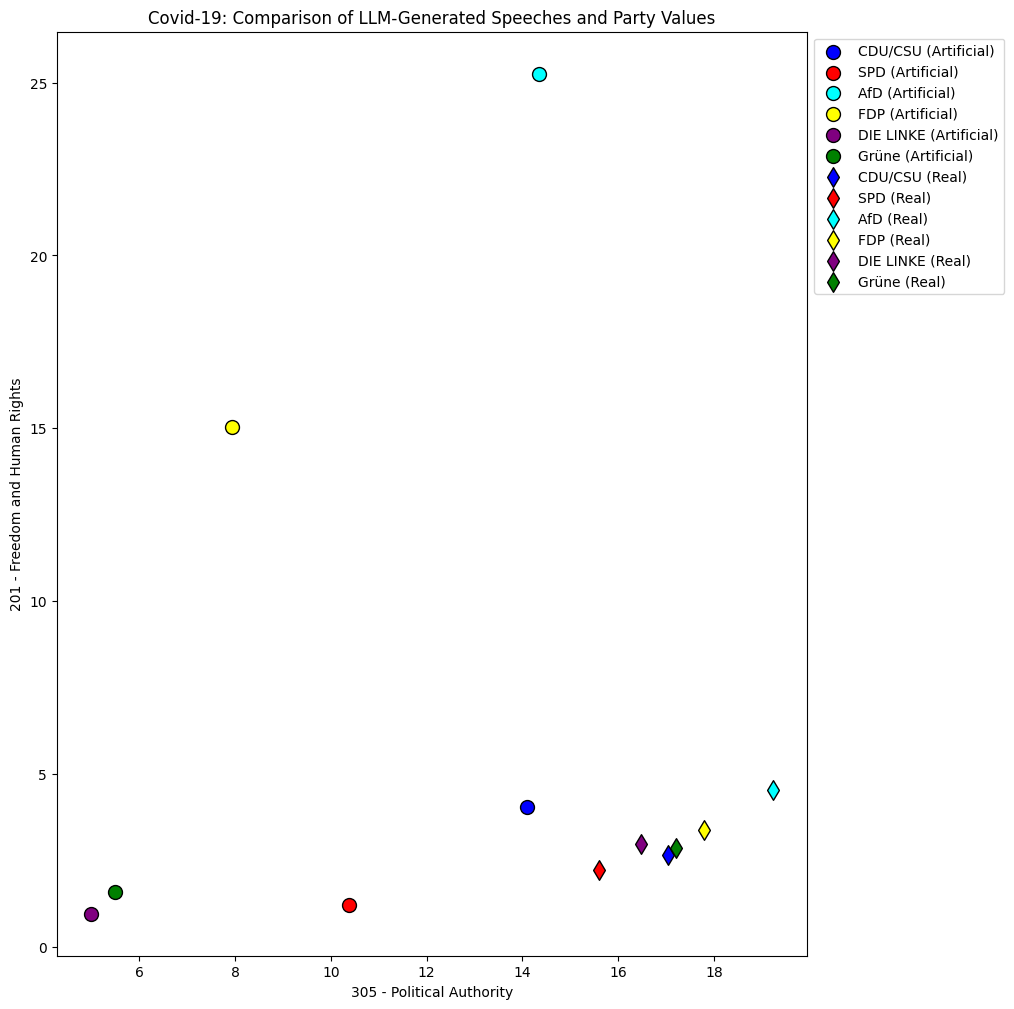

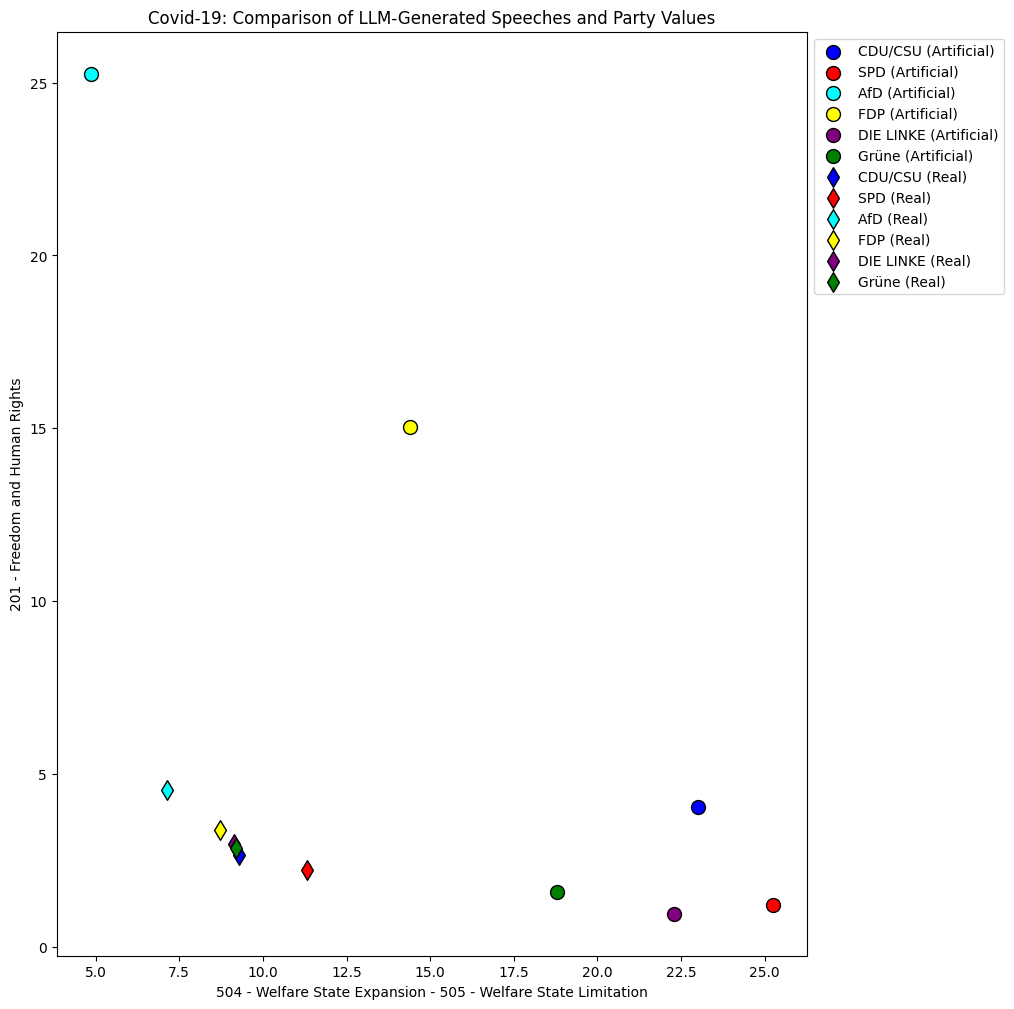

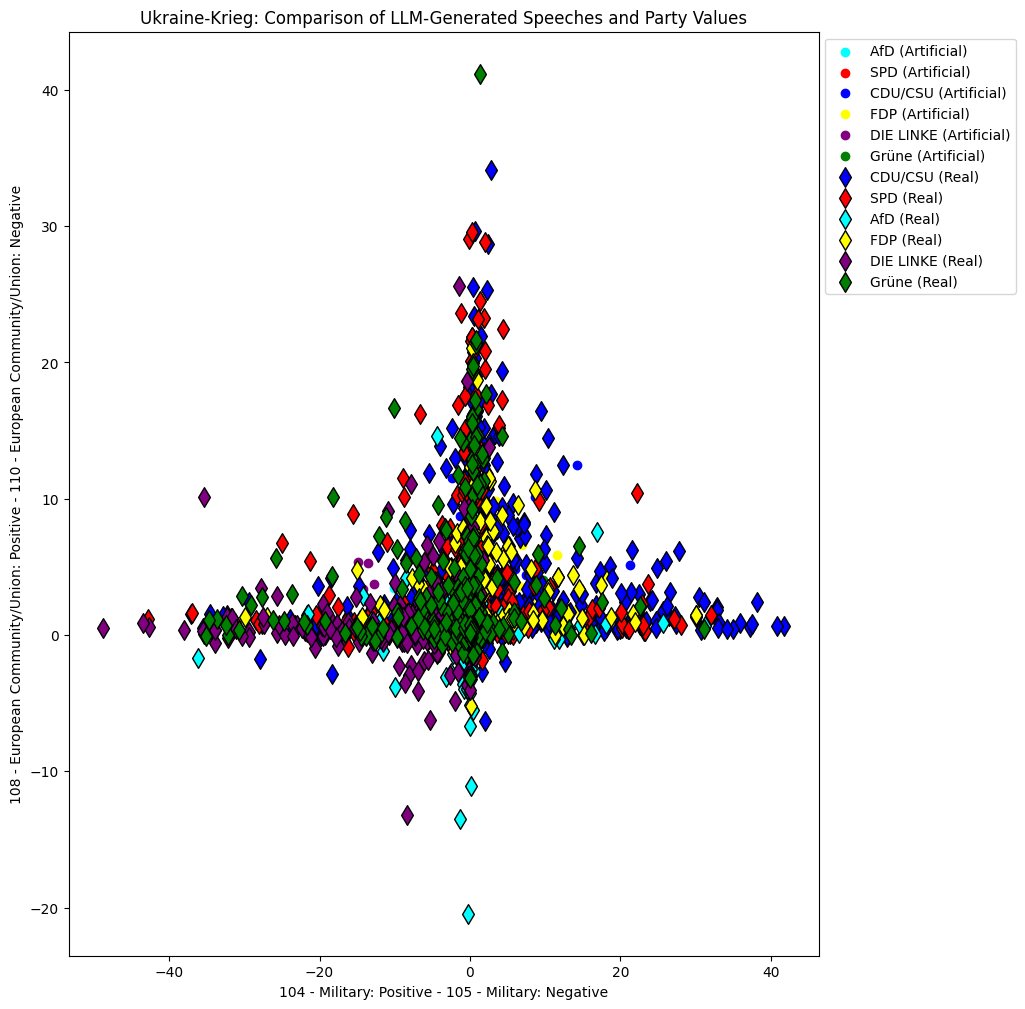

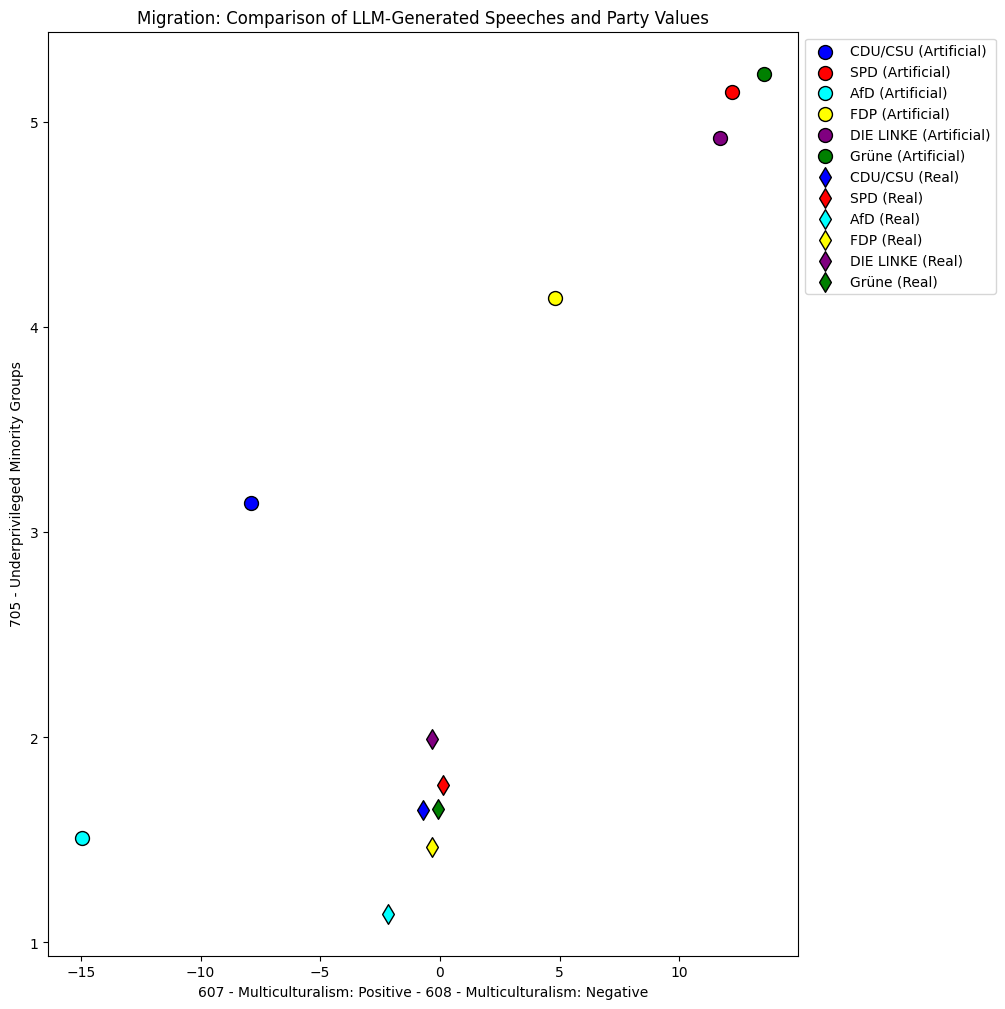

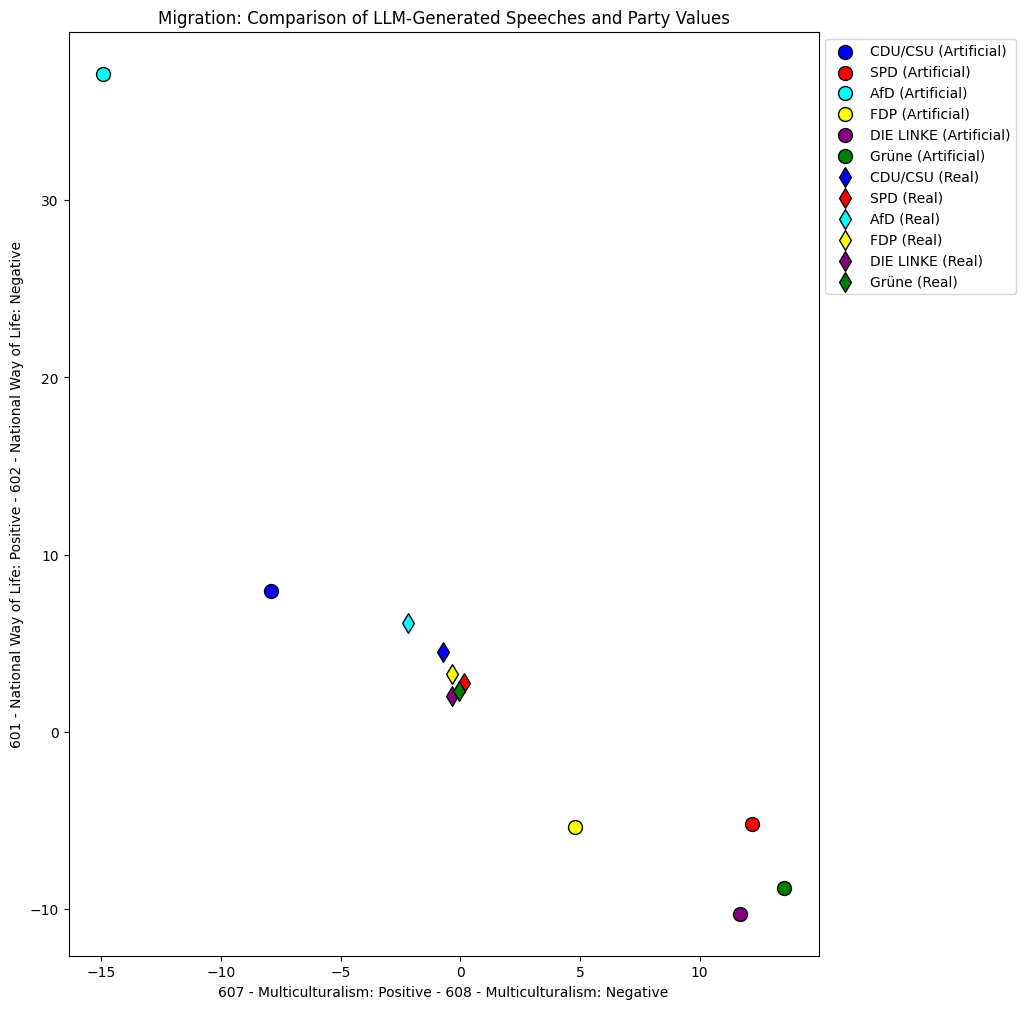

In [9]:
# Usage is described in function above
# I decided to focus on the following dimensions
# Covid: 
plot_dimension_comparison(llm_speeches=llm_speeches_party, df_speeches=covid_speeches, 
                          topic_of_interest='Covid-19', 
                          dims_x = ['305 - Political Authority'],
                          dims_y=['201 - Freedom and Human Rights'],
                          show_party_averages=True)

plot_dimension_comparison(llm_speeches=llm_speeches_party, df_speeches=covid_speeches, 
                          topic_of_interest='Covid-19', 
                          dims_x = ['504 - Welfare State Expansion', '505 - Welfare State Limitation'],
                          dims_y=['201 - Freedom and Human Rights'],
                          show_party_averages=True)


# Ukraine War:
plot_dimension_comparison(llm_speeches=llm_speeches_pol_party, df_speeches=ukraine_war_speeches, 
                          topic_of_interest='Ukraine-Krieg', 
                          dims_x = ['104 - Military: Positive', '105 - Military: Negative'],
                          dims_y=['108 - European Community/Union: Positive', '110 - European Community/Union: Negative'],
                            show_party_averages=False)


# Migration:
plot_dimension_comparison(llm_speeches=llm_speeches_pol_party, df_speeches=migration_speeches, 
                          topic_of_interest='Migration', 
                          dims_x = ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'],
                          dims_y=['705 - Underprivileged Minority Groups'],
                           show_party_averages=True)

plot_dimension_comparison(llm_speeches=llm_speeches_pol_party, df_speeches=migration_speeches, 
                          topic_of_interest='Migration', 
                          dims_x = ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'],
                          dims_y=['601 - National Way of Life: Positive','602 - National Way of Life: Negative'],
                           show_party_averages=True)



Looking at the average values, we get already an understanding of the data. To my suprise, are the artificial speeches more broadly spread out (ie., tend to have more extreme values) than the real speeches. This could be due to relatively wide filtering method applied to the real speeches (we decided to take a rather wide range of speeches with the risk of having non-ideal speeches in our data than having too little data to rate). It's also important to take into account that we have way more real speeches than AI-generated speeches, and therefore, the averages could be skewed/have a tendency for taking on not so extreme values.

However, overall the mapping of the parties on the political dimensions is in line with what we would expect. E.g., If we look at the last plot, we can see that the AfD has the highest value for National Way Of Life as well as the lowest value for Multiculturalism (AI and real speeches compared with each other). The CDU/CSU follows and on the opposite sid we can find the left-parties (DIE LINKE, SPD, Grüne). This overall trend of having a seemingly realistic evaluation can be found in every plot. 

Now, I am going to qualitatively evaluate the mapping of individual (real and artificial) speeches by looking at a random sample. 

Grüne
Sehr geehrte Damen und Herren, sehr geehrter Herr Präsident/ Frau Präsidentin, verehrte Kolleginnen und Kollegen!Wir stehen hier heute zusammen, um über ein Thema zu sprechen, das seit vielen Jahren, ja Jahrzehnten, unsere Gesellschaft und unsere Politik prägt – das Thema Migration.Migration ist keine temporäre Erscheinung, keine Eintagsfliege der Geschichte. Menschen ziehen umher seit Menschengedenken, über Grenzen und Kontinente hinweg, auf der Suche nach Sicherheit, nach einem besseren Leben, nach Chancen für sich und ihre Familien. Dieses Streben nach einem guten Leben ist tief in uns allen verankert – es ist universell, und es ist menschlich.Als Fraktion der Grünen sehen wir Migration nicht als Bedrohung, sondern als Chance und Bereicherung. Unsere Welt wächst zusammen, und wir sind überzeugt, dass Deutschland in diesem globalen Kontext eine aktive und positive Rolle spielen kann und muss.Wir Grüne setzen uns für eine menschenrechtsorientierte Migrationspolitik ein, die das 

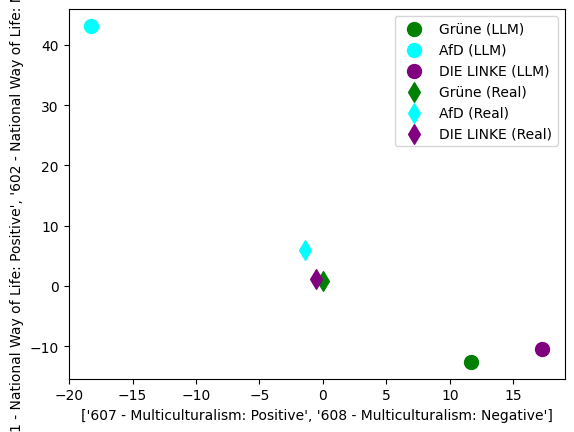

In [98]:
topic = 'Migration'
dims_x = ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative']
dims_y= ['601 - National Way of Life: Positive','602 - National Way of Life: Negative']
party_list = []
random.seed(42)
sample_party = random.sample(llm_speeches_party,3)
for sample in sample_party:
    party = sample['party']
    party_list.append(party)
    print(party)
    print(sample['llm_output'][topic][1])
    print(sample['manifestoberta_output'][topic][1])

    x_val = sample['manifestoberta_output'][topic][1][dims_x[0]] - sample['manifestoberta_output'][topic][1][dims_x[1]]
    y_val = sample['manifestoberta_output'][topic][1][dims_y[0]] - sample['manifestoberta_output'][topic][1][dims_y[1]]

    color = party_colors.get(sample['party'], 'grey')  # get party color from dict or use grey
    plt.scatter(x=x_val, y=y_val, color=color, s=100, label=party+' (LLM)', marker='o')
    plt.legend()
    plt.xlabel(dims_x)
    plt.ylabel(dims_y)

for party in party_list: # determined by our intitial sample
    sample = migration_speeches[migration_speeches['abbreviation'] == party].sample(1, random_state=42)
    speech_content = sample['speech_content']
    print(party)
    print(speech_content)
    x_val = sample[dims_x[0]] - sample[dims_x[1]]
    y_val = sample[dims_y[0]] - sample[dims_y[1]]
    color = party_colors.get(party,  'grey')  # get party color from dict or use grey
    plt.scatter(x=x_val, y=y_val, color=color, marker='d', s=100, label=party + " (Real)")
    plt.legend()

Looking at these examples, we can clearly identify why the real speeches are located rather in the middle of the dimension. While they do certainly touch on the topic ('Migration' in this case), they are not exclusively about it and focus on certain contexts (e.g., in the last speech the situation of refugees is discussed in the context of police activities in foreign countries) that differ from the topic of interest. The LLM-generated speeches on the other hand were exclusively about our topic of interest. However, overall I think the assignment of these values is appropriate for the LLM-generated speeches as well as the real speeches. Also, the overall impression of a very good performance of GPT-4 creating these speeches is demonstrated as I'd argue that the only possibility to identify the artificial speeches is by checking for the mentioning of granular topics (e.g., a certain law). But this could easily be evaded by prompting with such a granular topic, which would make the identification of LLM-generated content extremely difficult as the speeches would likely be indifferent from the original speeches.  

DIE LINKE Gesine Lötzsch
Sehr geehrte Damen und Herren, liebe Kolleginnen und Kollegen, verehrter Herr Präsident,wir stehen hier in einer Zeit, die wir uns noch vor wenigen Jahren kaum hätten vorstellen können. Eine Pandemie hat unseren Alltag, unsere Gewohnheiten und unser Gesundheitssystem auf eine harte Probe gestellt. Covid-19 ist mehr als eine Krankheit – es ist eine Herausforderung für die ganze Gesellschaft, für jeden Einzelnen von uns.Die Pandemie fordert von uns Solidarität, Geduld und vor allem das kompromisslose Engagement für den Schutz der Gesundheit. Als Mitglied der Partei DIE LINKE vertrete ich ein Menschenbild, das auf dem unveräußerlichen Wert jedes menschlichen Lebens basiert. Daher steht für mich außer Frage, dass die Gesundheit eines Jeden die höchste Priorität besitzt.Ich möchte an dieser Stelle an die vielen Helferinnen und Helfer in unserem Gesundheitssystem, an die Pflegekräfte, die Ärztinnen und Ärzte, die Reinigungskräfte und all die anderen, die im Hintergru

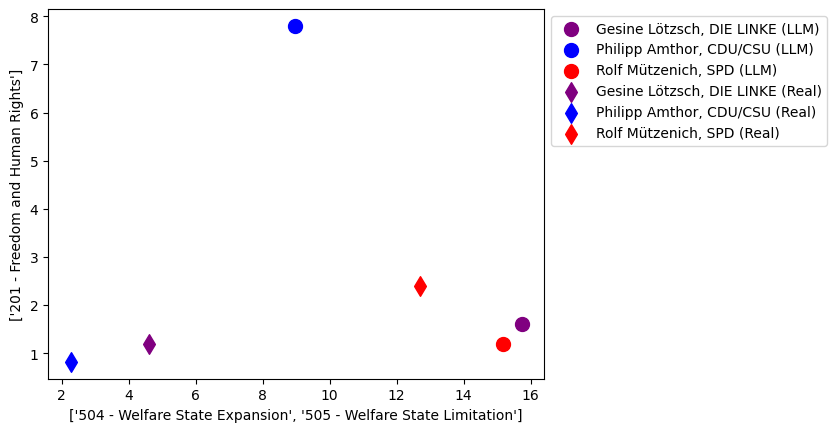

In [133]:
topic = 'Covid-19'
dims_x = ['504 - Welfare State Expansion', '505 - Welfare State Limitation']
dims_y= ['201 - Freedom and Human Rights']

random.seed(48)
sample_pol = random.sample(llm_speeches_pol,3)


party_list = []
name_list = []
for sample in sample_pol:
    party = sample['party']
    party_list.append(party)
    name = sample['name']
    name_list.append(name)
    print(party, name)
    print(sample['llm_output'][topic][1])

    x_val = sample['manifestoberta_output'][topic][1][dims_x[0]] - sample['manifestoberta_output'][topic][1][dims_x[1]]
    y_val = sample['manifestoberta_output'][topic][1][dims_y[0]] 

    color = party_colors.get(sample['party'], 'grey')  # get party color from dict or use grey
    plt.scatter(x=x_val, y=y_val, color=color, s=100, label=f'{name}, {party} (LLM)', marker='o')
    plt.legend()
    plt.xlabel(dims_x)
    plt.ylabel(dims_y)
print()

for name in name_list: # determined by our intitial sample
    first_name = name.split()[0]
    last_name = name.split()[1]
    sample = covid_speeches[(covid_speeches['first_name'] == first_name) & (covid_speeches['last_name'] == last_name)].sample(1, random_state=44)
    speech_content = sample['speech_content']
    party = sample['abbreviation'].values[0]
    print(party, name)
    print(speech_content)
    x_val = sample[dims_x[0]] - sample[dims_x[1]]
    y_val = sample[dims_y[0]] 
    color = party_colors.get(party,  'grey')  # get party color from dict or use grey
    plt.scatter(x=x_val, y=y_val, color=color, marker='d', s=100, label=f'{name}, {party} (Real)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


Here, we can see  that there is a quite a mismatch between the real and the artificial speeches. However, I'd argue that the generated speeches still reflect the politicians in their style. The difference in the numbers is likely due to a combination of 2 factors: 
- first, as already mentioned, the specificity of the real speeches (i.e., they touch on the selected topic, but do not exclusively focus on it and most of the time discuss a way smaller, rather concrete point instead of a broad topic)
- second, sample. We just sample 1 speech from each politician. To combat that point, we can use the following tool to see all generated and real speeches of a politician.  

In [209]:
topic_dimensions = { # decided to implement that at this point as these will be the dimensions we'll be focusing on. There are also some other potentially interesting dimensions, but we have to focus on some of them and can't inspect all of them deeply.
    'Covid-19': {
        'dims_x': ['504 - Welfare State Expansion', '505 - Welfare State Limitation'],
        'dims_y': ['201 - Freedom and Human Rights'], 
        'real_speeches': covid_speeches
    },
    'Migration': {
        'dims_x': ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'],
        'dims_y': ['601 - National Way of Life: Positive', '602 - National Way of Life: Negative'],
        'real_speeches':migration_speeches
    },
    'Ukraine-Krieg': {
        'dims_x': ['104 - Military: Positive', '105 - Military: Negative'],
        'dims_y': ['108 - European Community/Union: Positive', '110 - European Community/Union: Negative'], 
        'real_speeches':ukraine_war_speeches
    }}


def plot_speeches_for_politician_and_topic(politician_name, topic):
    if topic not in topic_dimensions:
        print(f"Topic '{topic}' not found in topic dimensions.")
        return
    
    dims_x = topic_dimensions[topic]['dims_x']
    dims_y = topic_dimensions[topic]['dims_y']
    real_speeches_df = topic_dimensions[topic]['real_speeches']
    
    first_name, last_name = politician_name.split()
    
    plt.figure(figsize=(12, 10))
    
    # plot LLM speeches from prompts without party (Politician Only)
    for sample in llm_speeches_pol:
        if sample['name'] == politician_name and topic in sample['llm_output']:
            for speech_data in sample['manifestoberta_output'][topic]:
                x_val = speech_data[dims_x[0]] # handle varying number of dimensions using if statements checking the lenght of the dimensions list given
                y_val = speech_data[dims_y[0]]
                if len(dims_x) >1: 
                    x_dim_2 = speech_data[dims_x[1]]
                    x_val = x_val - x_dim_2
                if len(dims_y) >1:
                    y_dim_2 = speech_data[dims_y[1]]
                    y_val = y_val - y_dim_2

                color = party_colors.get(sample['party'], 'grey')
                plt.scatter(x=x_val, y=y_val, color=color, s=100, label=f'{politician_name}, {sample["party"]} (LLM Politician Only)', marker='o')

    # plot LLM speeches for prompts with party and name (Politician + Party), use border on markers 
    for sample in llm_speeches_pol_party:
        if sample['name'] == politician_name and topic in sample['llm_output']:
            for speech_data in sample['manifestoberta_output'][topic]:
                x_val = speech_data[dims_x[0]] 
                y_val = speech_data[dims_y[0]]
                if len(dims_x) >1: 
                    x_dim_2 = speech_data[dims_x[1]]
                    x_val = x_val - x_dim_2
                if len(dims_y) >1:
                    y_dim_2 = speech_data[dims_y[1]]
                    y_val = y_val - y_dim_2
                color = party_colors.get(sample['party'], 'grey')
                plt.scatter(x=x_val, y=y_val, color=color, s=100, edgecolors='black', linewidth=2, label=f'{politician_name}, {sample["party"]} (LLM Politician + Party)', marker='o')

    # plot real speeches
    real_speeches = real_speeches_df[(real_speeches_df['first_name'] == first_name) & (real_speeches_df['last_name'] == last_name)]
    for _, sample in real_speeches.iterrows():
        x_val = sample[topic_dimensions[topic]['dims_x'][0]] 
        if len(dims_x) >1: 
            x_dim_2 = sample[topic_dimensions[topic]['dims_x'][1]] 
            x_val = x_val - x_dim_2
            
        y_val = sample[topic_dimensions[topic]['dims_y'][0]]
        if len(dims_y) >1:
            y_dim_2 = sample[topic_dimensions[topic]['dims_y'][1]]
            y_val = y_val - y_dim_2
        party = sample['abbreviation']
        color = party_colors.get(party, 'grey')
        plt.scatter(x=x_val, y=y_val, color=color, marker='d', s=100, label=f'{politician_name}, {party} (Real)')
    
    x_label = ' - '.join([d.split(' - ')[1] for d in dims_x]) # remove the numbers from labels
    y_label = ' - '.join([d.split(' - ')[1] for d in dims_y])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Speech Analysis for {politician_name} on {topic}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

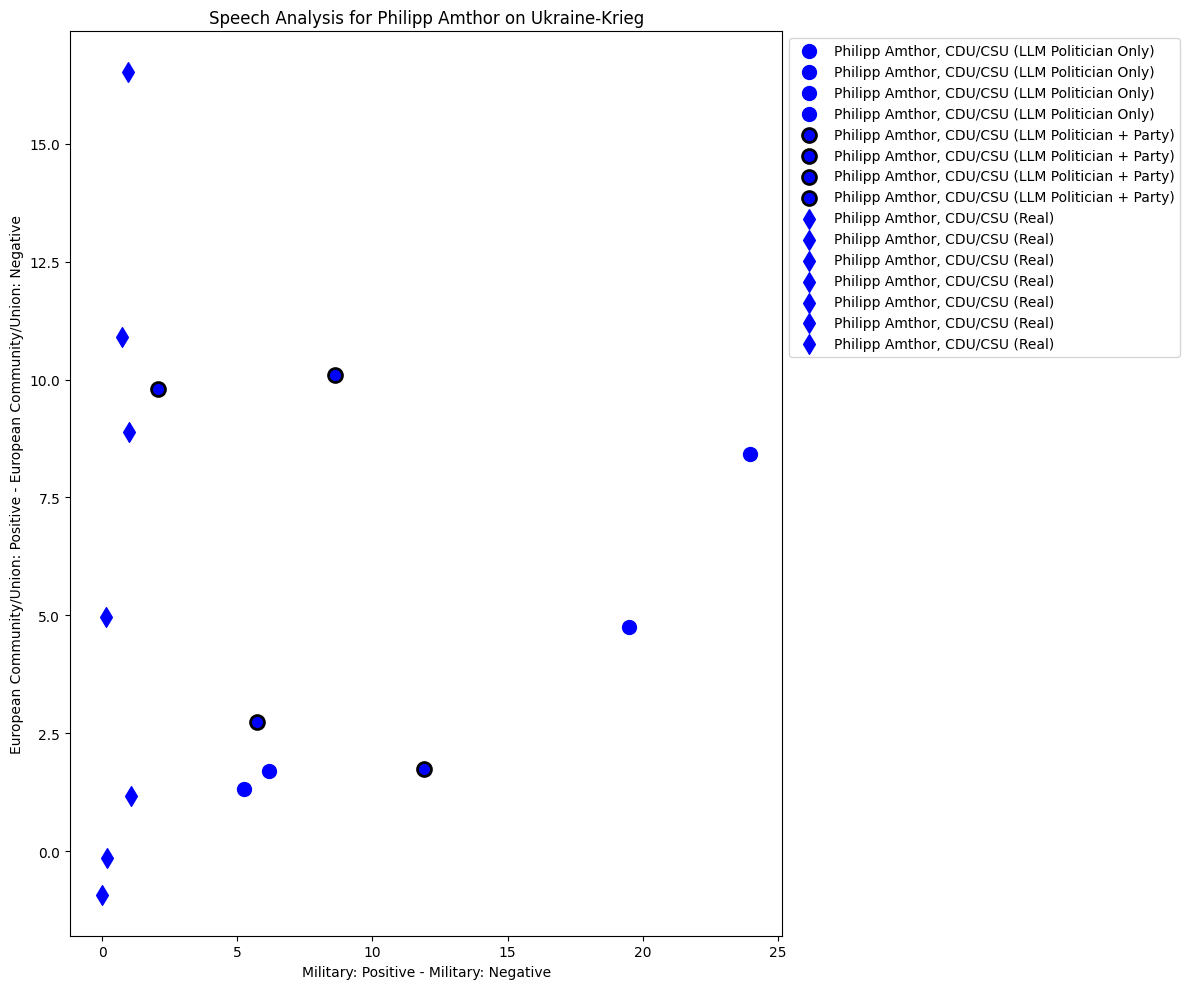

In [210]:
plot_speeches_for_politician_and_topic('Philipp Amthor', 'Ukraine-Krieg') # topics to choose from: 'Ukraine-Krieg', 'Covid-19', 'Migration'

In [236]:
llm_speeches_pol[0]['manifestoberta_output']
sums = defaultdict(int)
count = len(llm_speeches_pol[0]['manifestoberta_output'])
for output in llm_speeches_pol[0]['manifestoberta_output']['Ukraine-Krieg']: # for each politican
    for key, value in output.items(): # for each speech/run
        sums[key] += value
averages = {key: value / count for key, value in sums.items()}
print(averages)



# Calculate average for each key
averages = {key: value / count for key, value in sums.items()}
print(averages)

#´['Migration']


{'106 - Peace': 62.57666666666666, '107 - Internationalism: Positive': 20.526666666666667, '104 - Military: Positive': 7.023333333333333, '305 - Political Authority': 5.446666666666666, '408 - Economic Goals': 1.1733333333333331, '105 - Military: Negative': 6.599999999999999, '601 - National Way of Life: Positive': 4.133333333333333, '108 - European Community/Union: Positive': 4.71, '101 - Foreign Special Relationships: Positive': 0.9566666666666666, '414 - Economic Orthodoxy': 0.3766666666666667, '202 - Democracy': 2.866666666666667, '109 - Internationalism: Negative': 4.010000000000001, '503 - Equality: Positive': 0.8900000000000001, '103 - Anti-Imperialism': 1.8599999999999997, '403 - Market Regulation': 0.25999999999999995, '606 - Civic Mindedness: Positive': 1.9766666666666668, '416 - Anti-Growth Economy: Positive': 0.24666666666666667, '412 - Controlled Economy': 0.15666666666666668, '410 - Economic Growth: Positive': 0.15, '501 - Environmental Protection: Positive': 0.3, '201 - 

In [303]:
# Let's calculate the mean distances between the real speeches and the politician prompted speeches for the relevant dimensions first (then, maybe for all dimensions)
# the distances between the real and the politican+party prompted speeches
# should be stored in a df with first_name, last_name, abbreviation, topic, mean_dist_pol, mean_dist_pol_party, 


def calculate_averages(politician_name, topic, dict_to_be_used):
    # Assuming topic_dimensions is a pre-defined dictionary
    # and dims_x, dims_y are not used for filtering in this revision
    real_speeches_df = topic_dimensions[topic]['real_speeches']
    first_name, last_name = politician_name.split()

    sums = defaultdict(int)
    count = 0

    for politician_entry in dict_to_be_used:
        if politician_entry['name'] == politician_name:
            for speech_data in politician_entry['manifestoberta_output'][topic]:
                count += 1  # Increment count for each speech/run
                for key, value in speech_data.items():
                    sums[key] += value


    averages = {key: value / count for key, value in sums.items()}
 

    return averages

In [312]:
# get averages for real speeches
cols_starting_with_number = [col for col in covid_speeches.columns if col[0].isdigit()] # get all col starting with a digit as these are our dimensions
covid_averages_real = covid_speeches.groupby(['politician_id','first_name', 'last_name', 'abbreviation'])[cols_starting_with_number].mean()
migration_averages_real = migration_speeches.groupby(['politician_id','first_name', 'last_name', 'abbreviation'])[cols_starting_with_number].mean()
ukraine_war_averages_real = ukraine_war_speeches.groupby(['politician_id','first_name', 'last_name', 'abbreviation'])[cols_starting_with_number].mean()

# get averages for llm-generated speeches
# empty lists to hold data for DataFrame construction
data_pol = {topic: [] for topic in ['Covid-19', 'Ukraine-Krieg', 'Migration']}
data_pol_party = {topic: [] for topic in ['Covid-19', 'Ukraine-Krieg', 'Migration']}

for politician in llm_speeches_pol:
    for topic in ['Covid-19', 'Ukraine-Krieg', 'Migration']:
        politician_name = politician['name']
        first_name, last_name = politician_name.split()
        party = politician['party']
        average_values = calculate_averages(politician_name, topic, llm_speeches_pol)
        data_pol[topic].append({'first_name': first_name, 'last_name': last_name, 'abbreviation': party, **average_values})

for politician in llm_speeches_pol_party:
    for topic in ['Covid-19', 'Ukraine-Krieg', 'Migration']:
        politician_name = politician['name']
        first_name, last_name = politician_name.split()
        party = politician['party']
        average_values = calculate_averages(politician_name, topic, llm_speeches_pol_party)
        data_pol_party[topic].append({'first_name': first_name, 'last_name': last_name, 'abbreviation': party, **average_values}) # using **, we can easily fill up our dict with the column names

dfs_averages_pol = {topic: pd.DataFrame(data_pol[topic]) for topic in data_pol} # we convert each list of dicts with the average values to dfs, to acces the dfs, we use the topic as key
dfs_averages_pol_party = {topic: pd.DataFrame(data_pol_party[topic]) for topic in data_pol_party}



Index(['504 - Welfare State Expansion', '503 - Equality: Positive',
       '701 - Labour Groups: Positive', '305 - Political Authority',
       '603 - Traditional Morality: Positive',
       '706 - Non-economic Demographic Groups',
       '303 - Governmental and Administrative Efficiency',
       '506 - Education Expansion', '411 - Technology and Infrastructure',
       '202 - Democracy', '604 - Traditional Morality: Negative',
       '601 - National Way of Life: Positive',
       '606 - Civic Mindedness: Positive',
       '501 - Environmental Protection: Positive', '403 - Market Regulation',
       '201 - Freedom and Human Rights',
       '108 - European Community/Union: Positive', '402 - Incentives',
       '401 - Free Market Economy', '605 - Law and Order: Positive',
       '408 - Economic Goals', '107 - Internationalism: Positive',
       '505 - Welfare State Limitation', '412 - Controlled Economy',
       '703 - Agriculture and Farmers: Positive',
       '416 - Anti-Growth Economy

In [322]:
# Set indexes if they're not already
covid_averages_real.set_index(['politician_id', 'first_name', 'last_name', 'abbreviation'], inplace=True)
dfs_averages_pol['Covid-19'].set_index(['politician_id', 'first_name', 'last_name', 'abbreviation'], inplace=True)

# Ensure both DataFrames are aligned in terms of columns
columns_for_comparison = [col for col in covid_averages_real.columns if col[0].isdigit()]

# Calculate differences
differences = covid_averages_real[columns_for_comparison] - dfs_averages_pol['Covid-19'][columns_for_comparison]

# `differences` now contains the differences for each dimension between the real and LLM-generated speeches


KeyError: "None of ['politician_id', 'first_name', 'last_name', 'abbreviation'] are in the columns"

In [324]:
# To see the current index of the DataFrame
print("Current Index of covid_averages_real:", covid_averages_real.index)

# To see the current columns of the DataFrame
# print("Columns in covid_averages_real:", covid_averages_real.columns)


Current Index of covid_averages_real: MultiIndex([(      -1,     'Not found',              '',   'CDU/CSU'),
            (      -1,     'Not found',              '',       'FDP'),
            (      -1,     'Not found',              '',     'Grüne'),
            (      -1,     'Not found',              '',       'SPD'),
            (      -1,     'Not found',              '', 'not found'),
            (11000198,         'Peter',        'Bleser',   'CDU/CSU'),
            (11000365,  'Jörg Diether',    'Dehm-Desoi', 'DIE LINKE'),
            (11000756,        'Gregor',          'Gysi', 'DIE LINKE'),
            (11001023,          'Ulla',        'Jelpke', 'DIE LINKE'),
            (11001235,      'Wolfgang',       'Kubicki',       'FDP'),
            ...
            (11005258,        'Tobias',       'Winkler',   'CDU/CSU'),
            (11005259,          'Tina',     'Winklmann',     'Grüne'),
            (11005260,        'Janine',       'Wissler', 'DIE LINKE'),
            (11005261, 

In [321]:
import pandas as pd

# Assuming covid_averages_real and dfs_averages_pol['Covid-19'] are already defined

# Step 1: Merge the two DataFrames
merged_df = pd.merge(covid_averages_real.reset_index(), 
                     dfs_averages_pol['Covid-19'], 
                     on=['first_name', 'last_name', 'abbreviation'], 
                     suffixes=('_real', '_llm'))

# Step 2: Calculate the differences
# Identify columns that start with a number and are present in both dataframes
cols_starting_with_number = [col for col in merged_df.columns if col[0].isdigit() and '_real' in col]
differences = {}

for col in cols_starting_with_number:
    # Construct the name of the column in the LLM DataFrame
    llm_col_name = col.replace('_real', '_llm')
    if llm_col_name in merged_df.columns:
        # Calculate the difference and store it in a new column
        difference_col_name = f'diff_{col[:-5]}'
        merged_df[difference_col_name] = merged_df[col] - merged_df[llm_col_name]

# Step 3: The `merged_df` now contains the original columns plus the differences
# Optionally, you can create a new DataFrame containing only the differences along with the identifying columns
difference_cols = ['first_name', 'last_name', 'abbreviation'] + [col for col in merged_df.columns if 'diff_' in col]
differences_df = merged_df[difference_cols]

# differences_df contains the differences for each dimension between real and LLM-generated speeches for Covid-19
differences_df

,first_name,last_name,abbreviation,diff_504 - Welfare State Expansion,diff_503 - Equality: Positive,diff_701 - Labour Groups: Positive,diff_305 - Political Authority,diff_603 - Traditional Morality: Positive,diff_706 - Non-economic Demographic Groups,diff_303 - Governmental and Administrative Efficiency,...,diff_106 - Peace,diff_407 - Protectionism: Negative,diff_204 - Constitutionalism: Negative,diff_406 - Protectionism: Positive,diff_101 - Foreign Special Relationships: Positive,diff_415 - Marxist Analysis: Positive,diff_702 - Labour Groups: Negative,diff_103 - Anti-Imperialism,diff_507 - Education Limitation,diff_102 - Foreign Special Relationships: Negative
0,Dietmar,Bartsch,DIE LINKE,-9.924722,-6.256944,0.431389,13.534167,0.816667,0.657778,1.279444,...,1.055556e-01,0.061111,0.093333,0.113056,0.037222,0.048611,0.095833,0.083611,0.044444,0.030278
1,Alexander,Dobrindt,CDU/CSU,-1.392222,3.941944,1.940000,-5.459167,0.983611,0.938889,0.007222,...,-1.038889e-01,0.333889,0.050000,0.147778,0.029444,0.067222,0.021389,0.050278,0.018056,0.006667
2,Gesine,Lötzsch,DIE LINKE,-9.573500,-7.734500,1.713500,11.110500,-0.491000,0.663500,2.215000,...,4.140000e-01,0.054500,0.281000,0.057500,0.003500,0.391000,0.082000,0.063000,0.099500,0.015000
3,Rolf,Mützenich,SPD,-6.532955,-10.053636,3.164545,8.344318,0.344545,0.656591,0.792955,...,1.068636e+00,-0.117955,0.124091,0.064091,0.199773,0.004545,0.086136,0.208636,0.018864,0.046818
4,Heike,Hänsel,DIE LINKE,-18.705000,-15.125000,-2.377500,3.782500,0.387500,0.042500,-1.435000,...,9.950000e+00,0.175000,0.057500,0.067500,0.572500,-0.110000,0.042500,2.227500,0.012500,0.602500
5,Anton,Hofreiter,Grüne,-9.055000,-7.820000,2.257500,7.935000,0.407500,0.375000,1.782500,...,-1.750000e-02,0.092500,0.062500,0.077500,0.007500,0.025000,0.032500,0.015000,0.030000,0.002500
6,Omid,Nouripour,Grüne,-14.506389,-1.715000,0.648889,3.860556,0.443889,0.744444,-0.999722,...,4.507222e+00,0.059444,0.075556,0.106667,0.206667,0.051111,0.033056,0.788056,0.016667,0.170278
7,Christian,Lindner,FDP,-0.065333,1.718333,1.982833,2.248833,0.256667,0.666833,0.177333,...,4.000000e-02,0.184667,0.123167,0.076333,0.035167,0.054500,0.069167,0.044833,0.022667,0.014333
8,Stephan,Thomae,FDP,-3.352500,1.326667,1.868333,6.290833,0.720000,0.560000,1.360000,...,2.508333e-01,0.025000,0.510000,0.030000,0.125833,0.036667,0.057500,0.085000,0.016667,0.050000
9,Kathrin,Vogler,DIE LINKE,-12.334167,-11.311667,0.068333,20.075833,0.430000,0.419167,0.530000,...,3.691667e-01,0.114167,0.082500,0.213333,0.050833,0.005000,0.051667,0.103333,0.018333,0.069167


In [10]:
llm_speeches_pol[6].keys()

llm_speeches_pol[6]['manifestoberta_output']['Covid-19'][2] # empty dict

llm_speeches_pol[6]['llm_output']['Covid-19'][2]
speech = llm_speeches_pol[6]['llm_output']['Covid-19'][2]
print(speech)
speech = re.sub('\[.*?\]', '', speech)
print(f'Look: {speech}')


[Da ich kein echtes Skript oder Transkript von Karl-Heinz Brunner bezüglich seiner genauen Standpunkte und Ansichten zu COVID-19 habe, kann ich lediglich auf Basis seiner politischen Zugehörigkeit zur SPD und seiner öffentlichen Äußerungen eine Rede imaginieren, die sich an allgemeinem sozialdemokratischen Gedankengut orientiert.]Meine sehr geehrten Damen und Herren,wir stehen hier heute im Bundestag, nicht nur als Repräsentanten verschiedener politischer Ideen, sondern vereint unter der Verantwortung für das Wohl unserer Bürgerinnen und Bürger in Zeiten einer globalen Pandemie, die unsere Welt erschüttert hat.COVID-19 ist nicht nur eine gesundheitliche Herausforderung, sie ist auch eine ökonomische, soziale und politische Herausforderung, die von uns verlangt, zusammenzuarbeiten und Lösungen zu finden, die über den Tellerrand des Parteipolitischen hinausgehen.Als Mitglied der Sozialdemokratischen Partei Deutschlands stehe ich für ein solidarisches Miteinander, für den Schutz der Schwä

In [250]:
# Let's calculate variances per party
ukraine_war_speeches.columns
numeric_columns = [col for col in ukraine_war_speeches.columns if col[0].isdigit()]

variances_by_faction = ukraine_war_speeches.groupby('abbreviation')[numeric_columns].describe()

print(variances_by_faction)

             605 - Law and Order: Positive                                    \
                                     count      mean       std   min     25%   
abbreviation                                                                   
AfD                                  245.0  2.158041  2.918665  0.20  0.7700   
CDU/CSU                              975.0  2.761067  3.808700  0.25  0.9900   
DIE LINKE                            353.0  2.304929  2.543930  0.29  0.9000   
FDP                                  234.0  2.497137  2.860671  0.27  0.8925   
Fraktionslos                           5.0  0.874000  0.362395  0.47  0.6300   
Grüne                                434.0  2.389401  2.763592  0.27  0.8700   
SPD                                  560.0  2.648304  3.497177  0.30  0.8500   
not found                            234.0  3.171068  5.165349  0.33  1.0125   

                                  305 - Political Authority             ...  \
                50%    75%    max       

In [1]:
import matplotlib.pyplot as plt

# Define the color_map as given previously
# Assuming color_map is already defined

# Function to plot speeches analysis
def plot_speeches_analysis(df, x_columns, y_columns, x_label, y_label, title):
    plt.figure(figsize=(10, 10))
    for party, color in color_map.items():
        indices = [i for i, abbr in enumerate(df['abbreviation']) if abbr == party]
        x_values = df[x_columns[0]][indices] - df[x_columns[1]][indices] if len(x_columns) > 1 else df[x_columns[0]][indices]
        y_values = df[y_columns[0]][indices] - df[y_columns[1]][indices] if len(y_columns) > 1 else df[y_columns[0]][indices]
        plt.scatter(x_values, y_values, color=color, label=party)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(title="Party Association")
    plt.show()

# Plot for migration_speeches
plot_speeches_analysis(migration_speeches, 
                       ['607 - Multiculturalism: Positive', '608 - Multiculturalism: Negative'], 
                       ['705 - Underprivileged Minority Groups'], 
                       'Multiculturalism (Positive - Negative)', 
                       'Support for Underprivileged Minority Groups', 
                       'Migration Speeches Analysis')

# Plot for covid_speeches
plot_speeches_analysis(covid_speeches, 
                       ['506 - Education Expansion', '507 - Education Limitation'], 
                       ['404 - Economic Planning'], 
                       'Education (Expansion - Limitation)', 
                       'Economic Planning vs Market Regulation', 
                       'COVID-19 Speeches Analysis')
plot_speeches_analysis(ukraine_war_speeches,
                       ['104 - Military: Positive', '105 - Military: Negative'],
                       ['108 - European Community/Union: Positive', '110 - European Community/Union: Negative'],
                       'Military (Positive - Negative)',
                       'European Community/Union (Positive - Negative)',
                       'Ukraine War Speeches Analysis')



NameError: name 'migration_speeches' is not defined

In [57]:
# import os

# # Define the path where the new folder will be created
# folder_path = '/kaggle/working/outputs'

# # Check if the folder already exists
# if not os.path.exists(folder_path):
#     # If the folder does not exist, create it
#     os.makedirs(folder_path)
#     print(f"Folder '{folder_path}' created.")
# else:
#     print(f"Folder '{folder_path}' already exists.")

# ukraine_war_speeches.to_pickle('/kaggle/working/outputs/ukraine_war_speeches.pkl')
# migration_speeches.to_pickle('/kaggle/working/outputs/migration_speeches.pkl')
# covid_speeches.to_pickle('/kaggle/working/outputs/covid_speeches.pkl')


Folder '/kaggle/working/outputs' already exists.
